In [4]:
%load_ext autoreload
%autoreload 2

## Ising model
This notebook will explain the basics of the Ising model. In order to implement the different Ising Models we will use D-Wave's packages **[dimod](https://github.com/dwavesystems/dimod)** and **[neal](https://github.com/dwavesystems/dwave-neal)**, for defining the Ising model and solving it with simulated annealing, respectively.
#### Problem statement
We pose the Ising problem as the following optimization problem:
$$
\min_{\sigma \in \{ -1,+1 \}^n} H(\sigma) =\min_{\sigma \in \{ -1,+1 \}^n} \sum_{(ij) \in E(G)} J_{ij}\sigma_i\sigma_j + \sum_{i \in V(G)}h_i\sigma_i + c_I
$$
where we optimize over spins $\sigma \in \{ -1,+1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{ij}$ and the linear coefficients are $h_i$. We also include an arbitrary offset of the Ising model $c_I$.

In [5]:
# If using this on Google collab, we need to install the packages
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Let's start with Pyomo, dimod and neal
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [33]:
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx
import os
import pickle
from scipy import stats
from matplotlib import ticker
import pyomo.environ as pyo


We are interested in solving a Sherrington-Kirkpatrick model where random \(\pm 1\) interactions in the Hamiltonian between fully connected graphs are given. We have 5 instances, each with 50 nodes.

In [8]:
# Load instances from Filip
instances_dir = 'instances'
instances_prefix = 'sk_model_N_50_inst_'
instance = 1
with open(f"{instances_dir}/{instances_prefix}{instance}.pkl", 'rb') as filein:
    hamiltonian_dictionary = pickle.load(filein)

ModuleNotFoundError: No module named 'np_metric_quantification'

In [22]:
# Create own random instances
N = 50  # Number of variables
np.random.seed(42)  # Fixing the random seed to get the same result
J = np.random.choice([-1, 1], size=(N, N))
# J = np.random.rand(N, N)
# We only consider upper triangular matrix ignoring the diagonal
J = np.triu(J, 1)
h = np.zeros(N)

In [23]:
model_sk = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)


/tmp/ipykernel_989/1323328964.py:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  nx_graph = model_sk.to_networkx_graph()


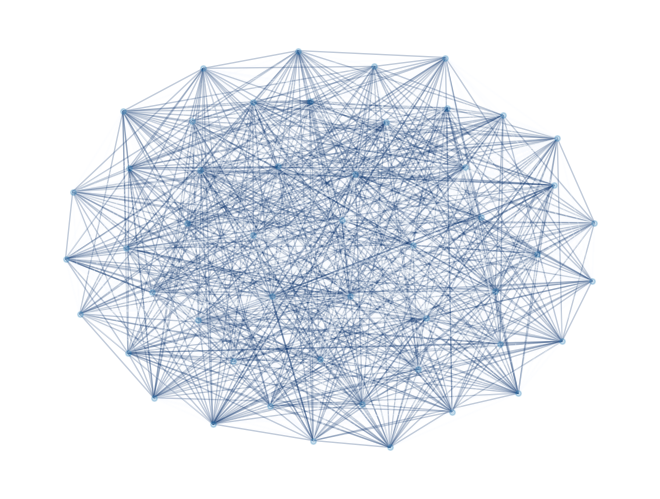

In [25]:
nx_graph = model_sk.to_networkx_graph()
edges, bias = zip(*nx.get_edge_attributes(nx_graph, 'bias').items())
bias = np.array(bias)
nx.draw(nx_graph, node_size=15, pos=nx.spring_layout(nx_graph),
        alpha=0.25, edgelist=edges, edge_color=bias, edge_cmap=plt.cm.Blues)


In [27]:
randomSampler = dimod.RandomSampler()
randomSample = randomSampler.sample(model_sk, num_reads=1000000)
energies = [datum.energy for datum in randomSample.data(
    ['energy'], sorted_by='energy')]
random_energy = np.mean(energies)
print('Average random energy = ' + str(random_energy))

Average random energy = 0.031392


In [28]:
# Some useful functions to get plots
def plot_energy_values(results, title=None):

    _, ax = plt.subplots()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        ax.set(xlabel='bitstring for solution')
    else:
        samples = np.arange(len(energies))
        ax.set(xlabel='solution')

    ax.bar(samples, energies)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Energy')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


def plot_samples(results, title=None, skip=1):
    _, ax = plt.subplots()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        ax.set_xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        ax.set_xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None, ax=ax)

    ax.tick_params(axis='x', rotation=80)
    ax.set_xticklabels([t.get_text()[:7] if not i %
                       skip else "" for i, t in enumerate(ax.get_xticklabels())])
    ax.set_ylabel('Probabilities')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


def plot_energy_cfd(results, title=None, skip=1):
    _, ax = plt.subplots()
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None, ax=ax)
    ax.set_xticklabels([t.get_text()[:7] if not i %
                       skip else "" for i, t in enumerate(ax.get_xticklabels())])

    ax.set_xlabel('Energy')
    ax.set_ylabel('Probabilities')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


minimum energy: -159.0


<AxesSubplot: title={'center': 'Random sampling'}, xlabel='Energy', ylabel='Probabilities'>

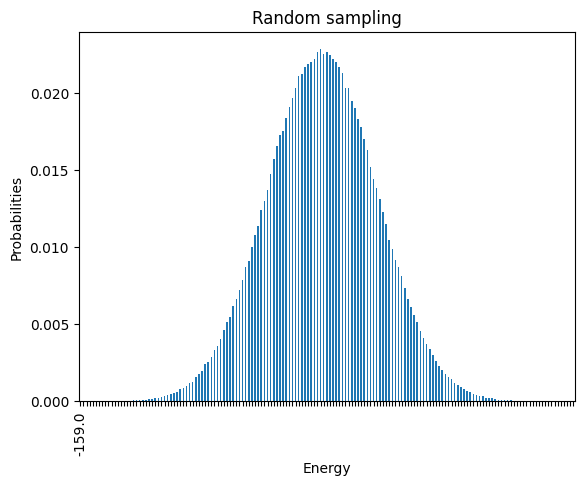

In [30]:
plot_energy_cfd(randomSample,
                   title='Random sampling',
                   skip=1000)


In [34]:
# We do not need to worry about the transformation to QUBO since dimod takes care of it
Q, c = model_sk.to_qubo()

# Define the model
model_pyo = pyo.ConcreteModel(name='QUBO example as an IP, 47-779/785 QuIPML')

I = range(len(model_sk))
J = range(len(model_sk))
#Define the original variables
model_pyo.x = pyo.Var(I, domain=pyo.Binary)
# Define the edges variables
model_pyo.y = pyo.Var(I, J, domain=pyo.Binary)

obj_expr = c

# add model constraints
model_pyo.c1 = pyo.ConstraintList()
model_pyo.c2 = pyo.ConstraintList()
model_pyo.c3 = pyo.ConstraintList()
for (i,j) in Q.keys():
    if i != j:
        model_pyo.c1.add(model_pyo.y[i,j] >= model_pyo.x[i] + model_pyo.x[j] - 1)
        model_pyo.c2.add(model_pyo.y[i,j] <= model_pyo.x[i])
        model_pyo.c3.add(model_pyo.y[i,j] <= model_pyo.x[j])
        obj_expr += Q[i,j]*model_pyo.y[i,j]
    else:
        obj_expr += Q[i,j]*model_pyo.x[i]

# Define the objective function
model_pyo.objective = pyo.Objective(expr = obj_expr, sense=pyo.minimize)
# Print the model
model_pyo.display()

Model 'QUBO example as an IP, 47-779/785 QuIPML'

  Variables:
    x : Size=50, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary
         10 :     0 :  None :     1 : False :  True : Binary
         11 :     0 :  None :     1 : False :  True : Binary
         12 :     0 :  None :     1 : False :  True : Binary
         13 :     0 :  None :     1 : False :  True 

In [35]:
opt_gurobi = pyo.SolverFactory('gurobi')

In [36]:
result_obj = opt_gurobi.solve(model_pyo, tee=False)
model_pyo.display()

    solver gurobi


ApplicationError: No executable found for solver 'gurobi'